### General steps to prepare data for xspec
    1) get complete_df with flags removed
    2) shift tus array in dataframe by tshift provided by cross_corrolate(). NOTE: ADDED to tus_ASIM
    3) use keV_bin() for binning of the energies
    4) change format of dataframe with this command: pd.set_option('display.float_format', '{:.6E}'.format)
    5) export to txt file with command: np.savetxt(r'/Users/andreas/phys/master/GRB/spectral_analysis/GRB190206A_keV_histogram.txt"',df_keV.values, delimiter=',', header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')



# imports

In [1]:
%run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb #MAC
#%run /Home/siv30/wad005/master/GRB/src/ASIMXspec.ipynb #UiB
#pd.set_option('display.float_format', '{:.6E}'.format)
#pd.reset_option("all")

all UiB paths loaded
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
safety_time.ipynb loaded successfully!
LC_calibration loaded successfully!


/Users/andreas/phys/master/FERMI/venv/lib/python3.7/site-packages/stingray/largememory.py:26: UserWarning: Large Datasets may not be processed efficiently due to computational constraints
  "Large Datasets may not be processed efficiently due to "


## ASIM

Creating df for short GRB
Absolute time correction subtracted from T0
78 valleys removed
erg converted to keV
df sorted by adr and tus
safety time events flagged. Found 95 flags
Removed 95 flags from df
df sorted by tus
2020-07-16 22:57:40.634534
first tus:  -197046.44444444444 | max tus:  1812317.0555555555
11787
tus array OK ...


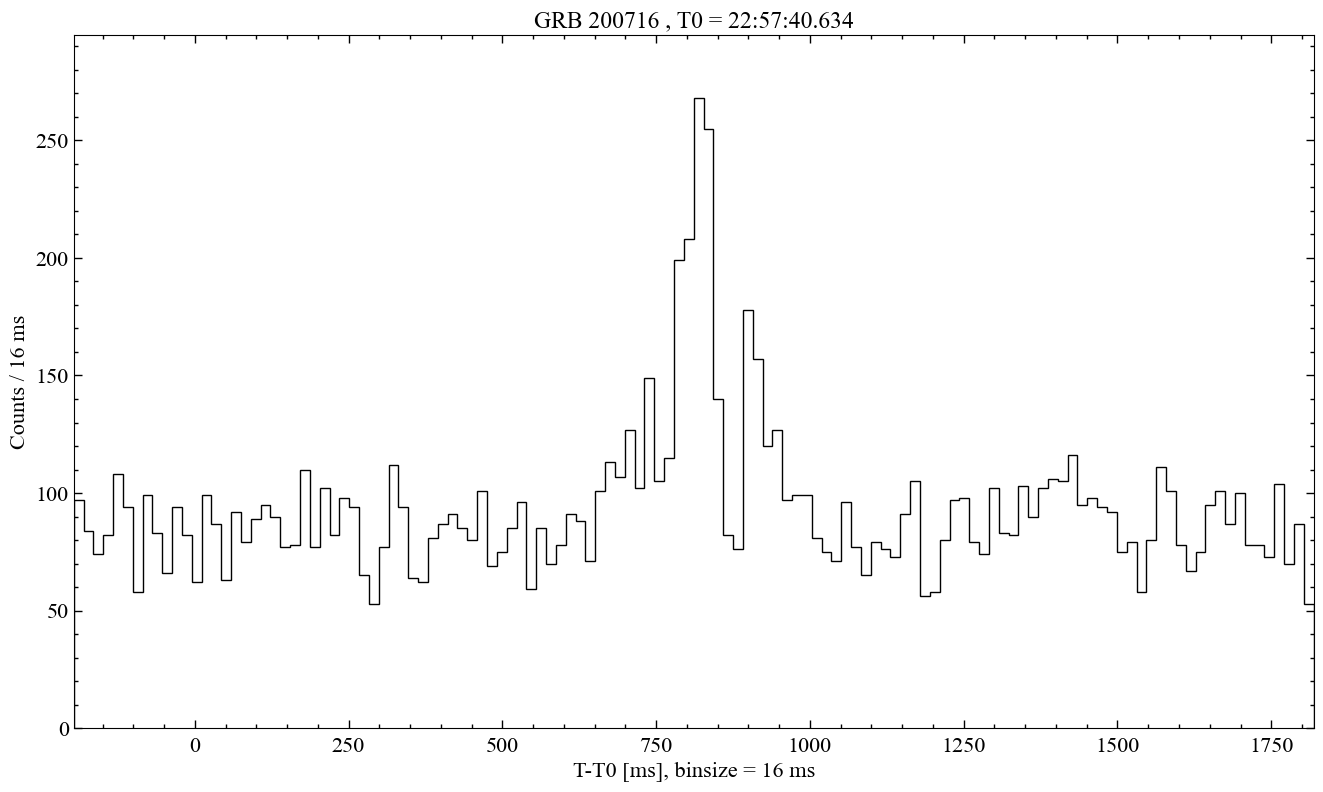

In [3]:
ASIM_df, T0_ASIM = complete_df(grb_id="GRB200716",remove_flag=True)
tus = ASIM_df["tus"].to_numpy(dtype=np.float64)
print(T0_ASIM)
print("first tus: ",min(tus),"| max tus: ", max(tus))
print(len(tus))
plot_HED(tus_arr=tus,T0=T0_ASIM,binsize=16)

### Global constants

In [72]:
binsize=0.016
ToF = 3.0155

tlagg with 2ms binsize: -0.687469637610192 s
tlagg with 16ms binsize: -0.6943048780487865

In [94]:
round(-0.687469637610192+0.6943048780487865,3)

0.007

## KW prep

In [73]:
kw_filename = "GRB200716C_16ms.txt"
kw_file = kw_lc_path + kw_filename

kw_df = pd.read_csv(kw_file,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float16), kw_df["Tf"].to_numpy(dtype=np.float16),kw_df["G1"].to_numpy(dtype=np.float16), kw_df["G2"].to_numpy(dtype=np.float16), kw_df["G3"].to_numpy(dtype=np.float16)

bin start:  -0.512 last bin start 0.496


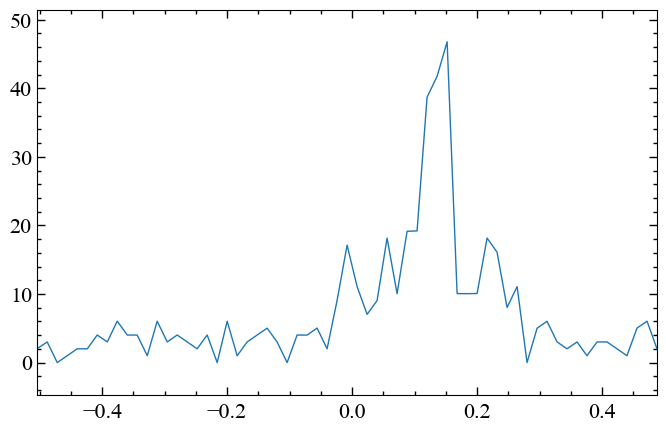

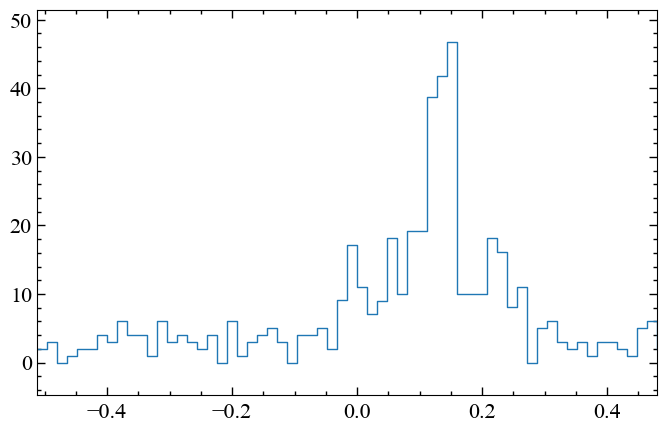

In [76]:
kw_dt = np.round(np.diff(kw_bin_lo),3)
i_stop_kw = find_nearest(kw_bin_lo,0.512)#np.where(kw_dt>binsize)[0][0]
print("bin start: ", kw_bin_lo[0], "last bin start",kw_bin_lo[i_stop_kw])

kw_bin_lo, kw_bin_hi, G1, G2, G3 = kw_bin_lo[:i_stop_kw], kw_bin_hi[:i_stop_kw], G1[:i_stop_kw],G2[:i_stop_kw], G3[:i_stop_kw]
kwCounts = G3
kwLC = LC(time=kw_bin_lo + binsize/2, counts=kwCounts, skip_checks=True,dt=binsize)
kwLC.plot()
plt.step(x=kw_bin_lo,y=G3,where="post")
plt.show()

kw_lc.plot(labels=["T-T0 [s]","counts/2ms"],title="GRB 201227A KW 360-1360 keV",
            save=True,filename="/Home/siv30/wad005/master/GRB/xspec/GRB201227A/CrossCorralation/KW_originalLC.png")

# CrossCorr
    TODO:
        -Make a function for finding the optimal tlagg
        -run the laggs array containing all of the possible tlaggs.
        -Time range (+- T s) selected from peak count rate pr bin

### ASIM prep

In [77]:
laggApprox = 40.634-ToF-38.337
print(np.round(laggApprox,3))

-0.719


asimBkg:  34.72222222222222


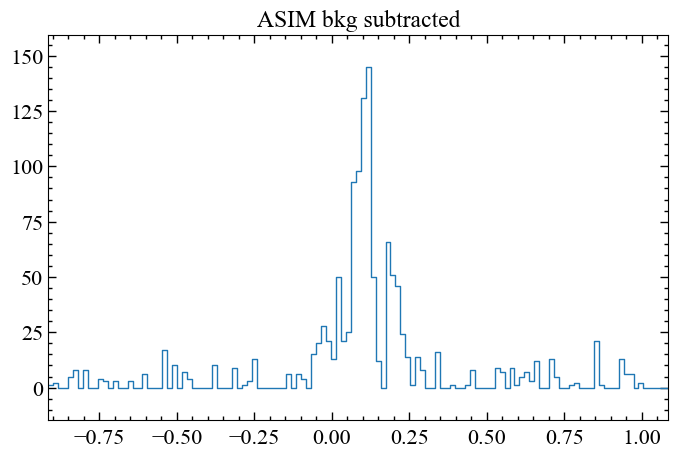

In [78]:
kevArr = ASIM_df["keV"].to_numpy(dtype=np.float32)
tus = ASIM_df["tus"].to_numpy(dtype=np.float64)/1e6 #converting to seconds
indexInBound = []
for i,kev in enumerate(kevArr):
    if 300<=kev<=1160:
        indexInBound.append(i)
kevArr = kevArr[indexInBound]
tus = tus[indexInBound]  
tus += laggApprox
#asim_binsOrg = np.round(np.arange(-1.5,2,binsize,dtype=np.float32),3)
asim_binsOrg = np.round(np.arange(min(tus),max(tus)+binsize,binsize),3)
hist = np.histogram(tus,bins=asim_binsOrg)
asimCounts,asimEdges = hist[0],hist[1]

iAsimBkgStart = find_nearest(asimEdges,min(asimEdges)+0.1)
iAsimBkgEnd = find_nearest(asimEdges,-0.25)
asimBkg = sum(asimCounts[iAsimBkgStart:iAsimBkgEnd])/len(asimCounts[iAsimBkgStart:iAsimBkgEnd])
print("asimBkg: ",asimBkg)
for i,count in enumerate(asimCounts):
    if count-asimBkg <= 0:
        asimCounts[i] = 0
    else:
        asimCounts[i] -= asimBkg

plt.step(x=asimEdges[:-1],y=asimCounts,where="post")
plt.title("ASIM bkg subtracted")
plt.show()


#df = pd.DataFrame(data={"Ti":np.round(asimEdges[:-1],3), "Tf":np.round(asimEdges[1:],3), "Counts":np.round(asimCounts,2)})
#np.savetxt(fname="asimLC_tshift_-0.531s",X=df,fmt=["%.3f","%.3f","%.2f"],header="Ti,Tf,Counts",delimiter=",")
#asimLC = LC(time=np.round(asimEdges[:-1],3)+binsize/2, counts=asimCounts, skip_checks=True,dt=binsize)

## Comparing LC's with approx tshift

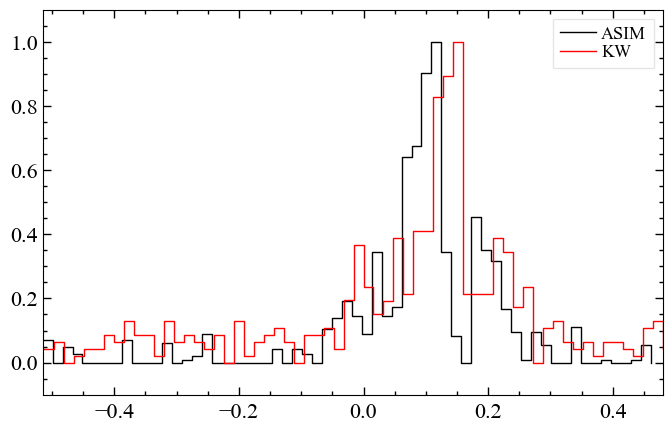

In [79]:
iAsimStart = find_nearest(asimEdges,kw_bin_lo[0])
iAsimEnd = find_nearest(asimEdges,kw_bin_lo[-1])


plt.step(x=asimEdges[iAsimStart:iAsimEnd],y=asimCounts[iAsimStart:iAsimEnd]/max(asimCounts),where="post",label="ASIM",color="black")
plt.step(x=kw_bin_lo,y=kwCounts/max(kwCounts),where="post",label="KW",color="red")
plt.legend()
plt.show()
#Good tlaggApprox, but ASIM needs to be shifted in + direction ~+0.03s

### building asimLC

In [82]:
asimLC = LC(time=asimEdges[iAsimStart:iAsimEnd]+binsize/2,counts=asimCounts[iAsimStart:iAsimEnd],dt=binsize,skip_checks=True)

asimLC.plot(labels=["T-T0 [s] ASIM ref. frame","counts/2ms"],title="GRB 201227A, ASIM 360-1360 keV",
            save=True,filename="/Home/siv30/wad005/master/GRB/xspec/GRB201227A/CrossCorralation/ASIM_originalLC.png")

## CC algo

Total lagg (s):  -0.6943048780487865 | CC lagg:  0.02419512195121945


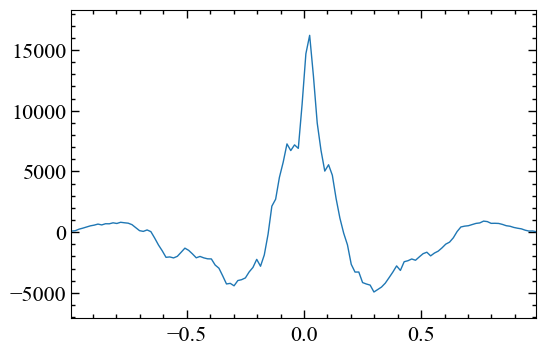

In [84]:
CC = CrossCorrelation(kwLC,asimLC,mode="full")
CClagg=CC.time_shift
tlagg = laggApprox + CClagg
print("Total lagg (s): ", tlagg, "| CC lagg: ", CClagg)
CC.plot()

# Building final LC's

asimBkg:  33.951219512195124


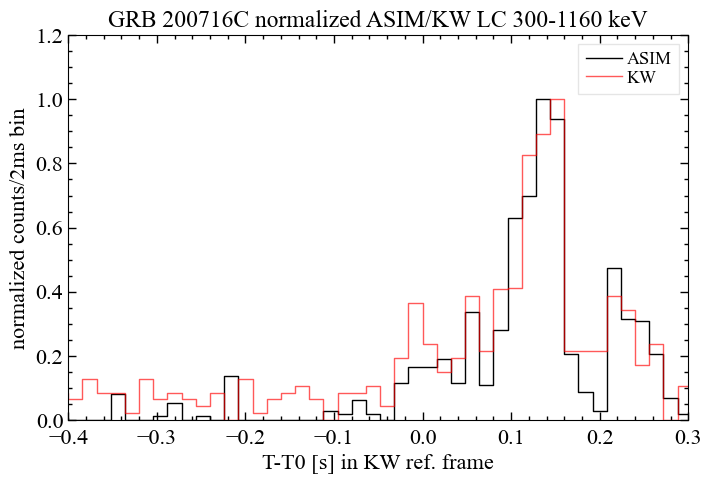

In [96]:
kevArr = ASIM_df["keV"].to_numpy(dtype=np.float32)
tus = ASIM_df["tus"].to_numpy(dtype=np.float64)/1e6 #converting to seconds
indexInBound = []
for i,kev in enumerate(kevArr):
    if 300<=kev<=1160:
        indexInBound.append(i)
kevArr = kevArr[indexInBound]
tus = tus[indexInBound]  
tus += tlagg
#asim_binsOrg = np.round(np.arange(-1.5,2,binsize,dtype=np.float32),3)
asim_binsOrg = np.round(np.arange(-1,1+binsize,binsize),3)
hist = np.histogram(tus,bins=asim_binsOrg)
asimCounts,asimEdges = hist[0],hist[1]

iAsimBkgStart = find_nearest(asimEdges,min(asimEdges)+0.1)
iAsimBkgEnd = find_nearest(asimEdges,-0.25)
asimBkg = sum(asimCounts[iAsimBkgStart:iAsimBkgEnd])/len(asimCounts[iAsimBkgStart:iAsimBkgEnd])
print("asimBkg: ",asimBkg)
for i,count in enumerate(asimCounts):
    if count-asimBkg <= 0:
        asimCounts[i] = 0
    else:
        asimCounts[i] -= asimBkg

iAsimStart = find_nearest(asimEdges,kw_bin_lo[0])
iAsimEnd = find_nearest(asimEdges,kw_bin_hi[-1])

plt.step(x=asimEdges[iAsimStart:iAsimEnd]+binsize/2,y=asimCounts[iAsimStart:iAsimEnd]/max(asimCounts),where="post",label="ASIM",color="black")
plt.step(x=kw_bin_lo,y=kwCounts/max(kwCounts),where="post",label="KW",color="red",alpha=0.65)

plt.title("GRB 200716C normalized ASIM/KW LC 300-1160 keV")
plt.xlabel("T-T0 [s] in KW ref. frame")
plt.ylabel("normalized counts/2ms bin")
#plt.vlines(x=0.0,ymin=0,ymax=1.1,color="g",label="T0: {}".format(T0_KW.isoformat(timespec="milliseconds")),alpha=0.6,linestyle="--")
plt.legend()
plt.xlim(left=-0.4,right=0.3)
plt.ylim(bottom=0,top=1.2)
#plt.savefig("/Home/siv30/wad005/master/GRB/xspec/GRB201227A/CrossCorrelation/overlappingLC_asim_kw.png")
plt.legend()
plt.show()
#Good tlaggApprox, but ASIM needs to be shifted in + direction ~+0.03s

In [92]:
#remember to check these
a = asimEdges[iAsimStart:iAsimEnd]
k = kw_bin_lo
a[0]+binsize/2,k[0]

(-0.512, -0.512)

### Approx shift

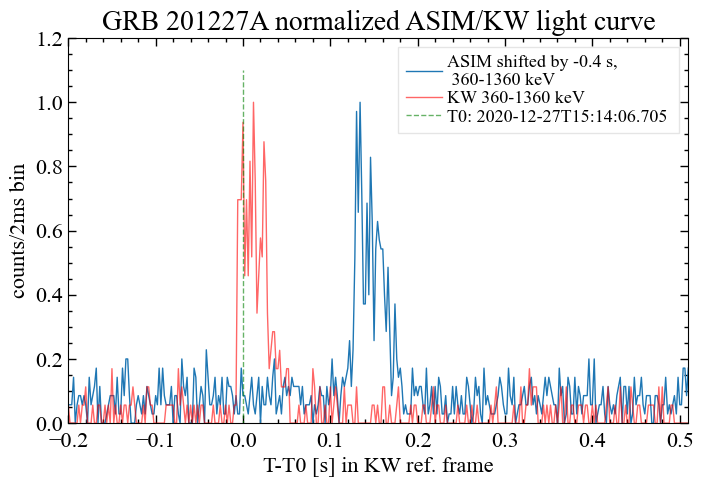

In [95]:
T0_approx = T0_ASIM+timedelta(seconds=laggApprox)
T0_KW = datetime.strptime("2020-12-27 15:14:06.705","%Y-%m-%d %H:%M:%S.%f")

plt.plot(np.round(asimCompare.bin_lo,3),asimCompare.counts/max(asimCompare),label="ASIM shifted by {} s, \n 360-1360 keV".format(laggApprox))
plt.plot(np.round(kwCompare.bin_lo,3),kwCompare.counts/max(kwCompare),c="r",alpha=0.6,label="KW 360-1360 keV")

plt.title("GRB 201227A normalized ASIM/KW light curve")
plt.xlabel("T-T0 [s] in KW ref. frame")
plt.ylabel("counts/2ms bin")
plt.vlines(x=0.0,ymin=-0.1,ymax=1.1,color="g",label="T0: {} ".format(T0_KW.isoformat(timespec='milliseconds')),alpha=0.6,linestyle="--")
plt.legend()
plt.ylim(bottom=0,top=1.2)
plt.xlim(left=-0.2,right=max(kwCompare.bin_lo))
plt.savefig("/Home/siv30/wad005/master/GRB/xspec/GRB201227A/CrossCorrelation/ASIM_KW_AppShift.png")
plt.show()

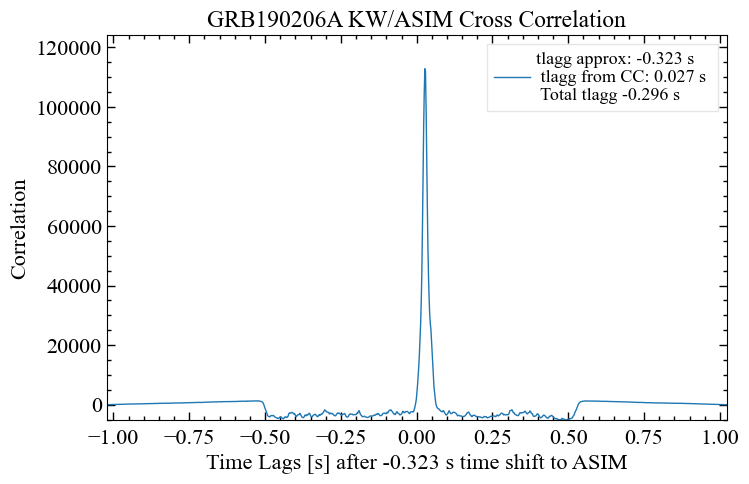

In [72]:
plt.plot(CC.time_lags,CC.corr,label="tlagg approx: {} s \n tlagg from CC: {} s \n Total tlagg {} s".format(np.round(laggApprox,3), np.round(CClagg,3), np.round(tlagg,3)))
plt.title("GRB190206A KW/ASIM Cross Correlation")
plt.xlabel('Time Lags [s] after {} s time shift to ASIM'.format(np.round(laggApprox,3)))
plt.ylabel('Correlation')
plt.legend()
plt.ylim(bottom=min(CC.corr),top=max(CC.corr)+max(CC.corr)/1e1)
#plt.savefig("/Home/siv30/wad005/master/GRB/xspec/GRB201227A/CrossCorrelation/CC_asim_kw.png")
plt.show()

# Extracting ASIM data

In [73]:
ASIM_df,T0 = complete_df(grb_id="GRB190206",remove_flag=True)
T0_shift = T0 + timedelta(seconds=tlagg)
ASIM_df["tus"] = ASIM_df["tus"].to_numpy()+tlagg*1e6

Creating df for short GRB
Absolute time correction subtracted from T0
187 valleys removed
erg converted to keV
df sorted by adr and tus
safety time events flagged. Found 287 flags
Removed 287 flags from df
df sorted by tus


tus array OK ...


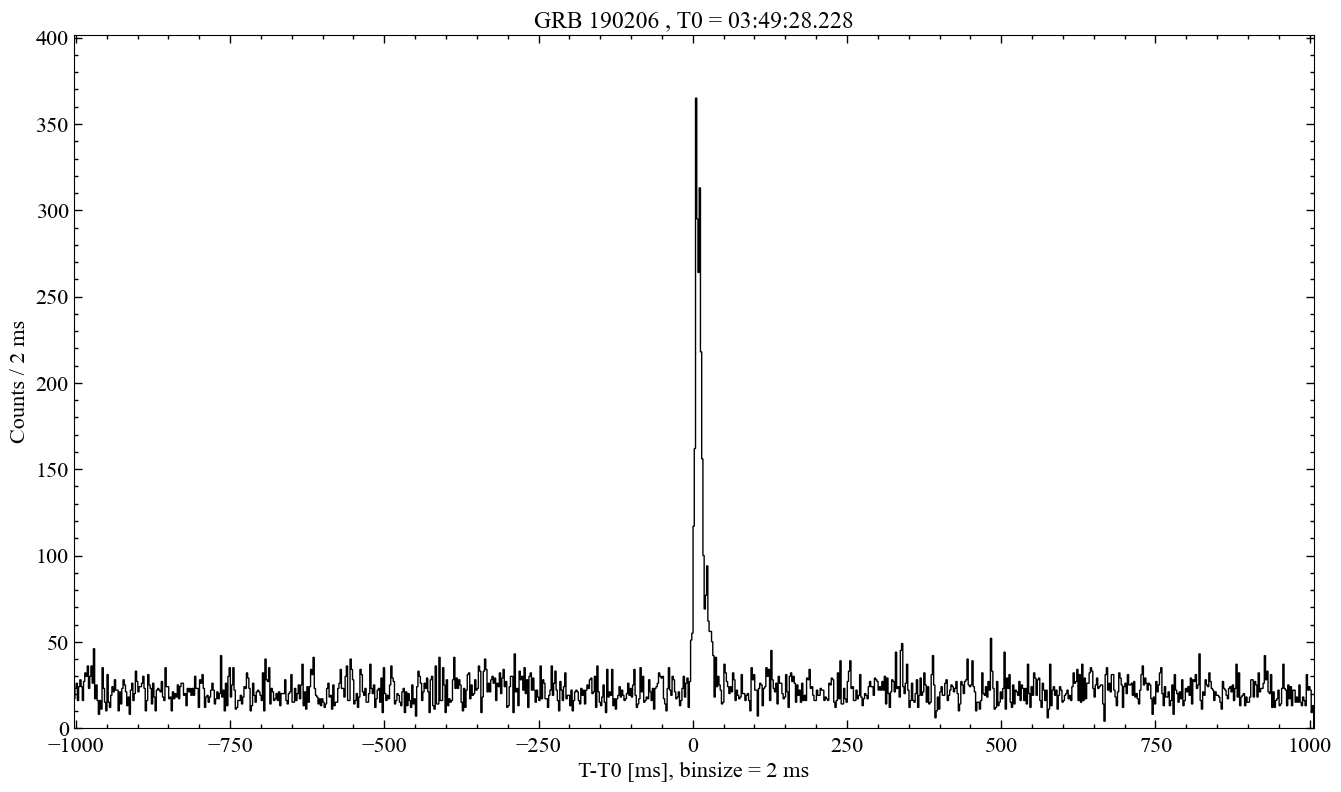

In [74]:
plot_HED(tus_arr=ASIM_df["tus"].to_numpy(),T0=T0_shift,binsize=2)

In [ ]:
keV_df = keV_hist(df=ASIM_df,time_interval=(0,0.064),
                 keV_interval="max",
                 duration=0.064,
                 )
keV_df
#All triggers in the time_interval are kept

In [ ]:
#np.savetxt(r'/Home/siv30/wad005/master/GRB/xspec/GRB201227A/ASIM201227.txt',keV_df.values, delimiter=',', header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')

### bakground extraction 

keV_bg = keV_hist(df=ASIM_df,time_interval=(-0.9,-0.3),
                 keV_interval="max",
                 duration=0.6,
                 )

In [14]:
#np.savetxt(r'/Home/siv30/wad005/master/GRB/xspec/GRB201227A/ASIM201227_bg.txt',keV_bg.values, delimiter=',', header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')